# Session 3: Unsupervised and Supervised Learning

<p class="lead">
Parag K. Mital<br />
<a href="https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow/info">Creative Applications of Deep Learning w/ Tensorflow</a><br />
<a href="https://www.kadenze.com/partners/kadenze-academy">Kadenze Academy</a><br />
<a href="https://twitter.com/hashtag/CADL">#CADL</a>
</p>


<a name="learning-goals"></a>
# Learning Goals

* Build an autoencoder w/ linear and convolutional layers
* Understand how one hot encodings work
* Build a classification network w/ linear and convolutional layers

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [Introduction](#introduction)
- [Unsupervised vs. Supervised Learning](#unsupervised-vs-supervised-learning)
- [Autoencoders](#autoencoders)
    - [MNIST](#mnist)
    - [Fully Connected Model](#fully-connected-model)
    - [Convolutional Autoencoder](#convolutional-autoencoder)
    - [Denoising Autoencoder](#denoising-autoencoder)
    - [Variational Autoencoders](#variational-autoencoders)
- [Predicting Image Labels](#predicting-image-labels)
    - [One-Hot Encoding](#one-hot-encoding)
    - [Using Regression for Classification](#using-regression-for-classification)
    - [Fully Connected Network](#fully-connected-network)
    - [Convolutional Networks](#convolutional-networks)
- [Saving/Loading Models](#savingloading-models)
    - [Checkpoint](#checkpoint)
    - [Protobuf](#protobuf)
- [Wrap Up](#wrap-up)
- [Reading](#reading)

<!-- /MarkdownTOC -->

<a name="introduction"></a>
# Introduction

In the last session we created our first neural network.

We saw that in order to create a neural network, we needed to define a cost function which would allow gradient descent to optimize all the parameters in our network <TODO: Insert animation of gradient descent from previous session>.  We also saw how neural networks become much more expressive by introducing series of linearities followed by non-linearities, or activation functions.  <TODO: Insert graphic of activation functions from previous session>.

We then explored a fun application of neural networks using regression to learn to paint color values given x, y positions.  This allowed us to build up a sort of painterly like version of an image.

In this session, we'll see how to use some simple deep nets with about 3 or 4 layers capable of performing unsupervised and supervised learning, and I'll explain those terms in a bit.  The components we learn here will let us explore data in some very interesting ways.

<a name="unsupervised-vs-supervised-learning"></a>
# Unsupervised vs. Supervised Learning

Machine learning research in deep networks performs one of two types of learning.  You either have a lot of data and you want the computer to reason about it, maybe to encode the data using less data, and just explore what patterns there might be.  That's useful for clustering data, reducing the dimensionality of the data, or even for generating new data.  That's generally known as unsupervised learning.  In the supervised case, you actually know what you want out of your data.  You have something like a label or a class that is paired with every single piece of data.  In this first half of this session, we'll see how unsupervised learning works using something called an autoencoder and how it can be extended using convolution..  Then we'll get into supervised learning and show how we can build networks for performing regression and classification.  By the end of this session, hopefully all of that will make a little more sense.  Don't worry if it doesn't yet!  Really the best way to learn is to put this stuff into practice in the homeworks.

<a name="autoencoders"></a>
# Autoencoders

<TODO: Graphic of autoencoder network diagram>

An autoencoder is a type of neural network that learns to encode its inputs, often using much less data.  It does so in a way that it can still output the original input with just the encoded values.  For it to learn, it does not require "labels" as its output.  Instead, it tries to output whatever it was given as input.  So in goes an image, and out should also go the same image.  But it has to be able to retain all the details of the image, even after possibly reducing the information down to just a few numbers.

We'll also explore how this method can be extended and used to cluster or organize a dataset, or to explore latent dimensions of a dataset that explain some interesting ideas.  For instance, we'll see how with handwritten numbers, we will be able to see how each number can be encoded in the autoencoder without ever telling it which number is which.

<TODO: place teaser of MNIST video learning>

But before we get there, we're going to need to develop an understanding of a few more concepts.

First, imagine a network that takes as input an image.  The network can be composed of either matrix multiplications or convolutions to any number of filters or dimensions.  At the end of any processing, the network has to be able to recompose the original image it was input.

In the last session, we saw how to build a network capable of taking 2 inputs representing the row and column of an image, and predicting 3 outputs, the red, green, and blue colors.  Instead if having 2 inputs, we'll now have an entire image as an input, the brightness of every pixel in our image.  And as output, we're going to have the same thing, the entire image being output.

<a name="mnist"></a>
## MNIST

Let's first get some standard imports:

In [1]:
# imports
%matplotlib inline
# %pylab osx
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
# Some additional libraries which we'll use just
# to produce some visualizations of our training
from libs.utils import montage
from libs import gif
import IPython.display as ipyd
plt.style.use('ggplot')

# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

Then we're going to try this with the MNIST dataset, which I've included a simple interface for in the `libs` module.

In [2]:
from libs.datasets import MNIST
ds = MNIST()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Let's take a look at what this returns:

In [3]:
 #ds.<tab>

So we can see that there are a few interesting accessors.  ... we're not going to worry about the labels until a bit later when we talk about a different type of model which can go from the input image to predicting which label the image is.  But for now, we're going to focus on trying to encode the image and be able to reconstruct the image from our encoding.  let's take a look at the images which are stored in the variable `X`.  Remember, in this course, we'll always use the variable `X` to denote the input to a network. and we'll use the variable `Y` to denote its output.

In [4]:
print(ds.X.shape)

(70000, 784)


So each image has 784 features, and there are 70k of them.  If we want to draw the image, we're going to have to reshape it to a square.  28 x 28 is 784.  So we're just going to reshape it to a square so that we can see all the pixels arranged in rows and columns instead of one giant vector.

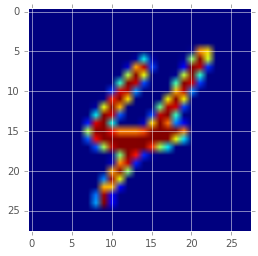

In [5]:
plt.imshow(ds.X[0].reshape((28, 28)))

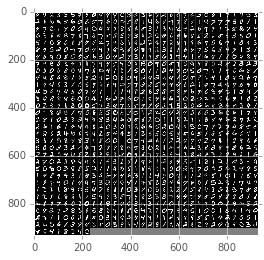

In [6]:
# Let's get the first 1000 images of the dataset and reshape them
imgs = ds.X[:1000].reshape((-1, 28, 28))

# Then create a montage and draw the montage
plt.imshow(montage(imgs), cmap='gray')

Let's take a look at the mean of the dataset:

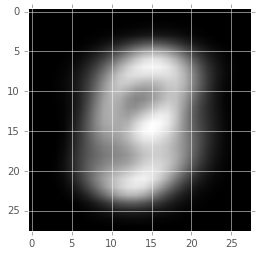

In [7]:
# Take the mean across all images
mean_img = np.mean(ds.X, axis=0)

# Then plot the mean image.
plt.figure()
plt.imshow(mean_img.reshape((28, 28)), cmap='gray')

And the standard deviation

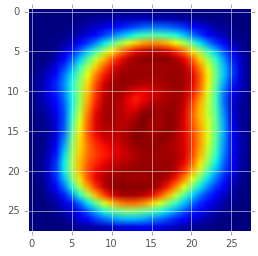

In [8]:
# Take the std across all images
std_img = np.std(ds.X, axis=0)

# Then plot the std image.
plt.figure()
plt.imshow(std_img.reshape((28, 28)))

So recall from session 1 that these two images are really saying whats more or less contant across every image, and what's changing.  We're going to try and use an autoencoder to try to encode everything that could possibly change in the image.

<a name="fully-connected-model"></a>
## Fully Connected Model

To try and encode our dataset, we are going to build a series of fully connected layers that get progressively smaller.  So in neural net speak, every pixel is going to become its own input neuron.  And from the original 784 neurons, we're going to slowly reduce that information down to smaller and smaller numbers.  It's often standard practice to use other powers of 2 or 10.  I'll create a list of the number of dimensions we'll use for each new layer.

In [9]:
dimensions = [512, 256, 128, 64]

So we're going to reduce our 784 dimensions down to 512 by multiplyling them by a 784 x 512 dimensional matrix.  Then we'll do the same thing again using a 512 x 256 dimensional matrix, to reduce our dimensions down to 256 dimensions, and then again to 128 dimensions, then finally to 64.  To get back to the size of the image, we're going to just going to do the reverse.  But we're going to use the exact same matrices.  We do that by taking the transpose of the matrix, which reshapes the matrix so that the rows become columns, and vice-versa.  So our last matrix which was 128 rows x 64 columns, when transposed, becomes 64 rows x 128 columns.

So by sharing the weights in the network, we're only really learning half of the network, and those 4 matrices are going to make up the bulk of our model.  We just have to find out what they are using gradient descent.

We're first going to create `placeholders` for our tensorflow graph.  We're going to set the first dimension to `None`.  This is something special for placeholders which tells tensorflow "let this dimension be any possible value".  1, 5, 100, 1000, it doesn't matter.  We're going to pass our entire dataset in minibatches.  So we'll send 100 images at a time.  But we'd also like to be able to send in only 1 image and see what the prediction of the network is.  That's why we let this dimension be flexible in the graph.

In [10]:
# So the number of features is the second dimension of our inputs matrix, 784
n_features = ds.X.shape[1]

# And we'll create a placeholder in the tensorflow graph that will be able to get any number of n_feature inputs.
X = tf.placeholder(tf.float32, [None, n_features])

Now we're going to create a network which will perform a series of multiplications on `X`, followed by adding a bias, and then wrapping all of this in a non-linearity:

In [11]:
# let's first copy our X placeholder to the name current_input
current_input = X
n_input = n_features

# We're going to keep every matrix we create so let's create a list to hold them all
Ws = []

# We'll create a for loop to create each layer:
for layer_i, n_output in enumerate(dimensions):

    # just like in the last session,
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):

        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

        # Now we'll multiply our input by our newly created W matrix
        # and add the bias
        h = tf.matmul(current_input, W)

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # Finally we'll store the weight matrix so we can build the decoder.
        Ws.append(W)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

So now we've created a series of multiplications in our graph which take us from our input of batch size times number of features which started as `None` x `784`, and then we're multiplying it by a series of matrices which will change the size down to `None` x `64`.

In [12]:
print(current_input.get_shape())

(?, 64)


In order to get back to the original dimensions of the image, we're going to reverse everything we just did.  Let's see how we do that:

In [13]:
# We'll first reverse the order of our weight matrices
Ws = Ws[::-1]

# then reverse the order of our dimensions
# appending the last layers number of inputs.
dimensions = dimensions[::-1][1:] + [ds.X.shape[1]]
print(dimensions)

[128, 256, 512, 784]


In [14]:
for layer_i, n_output in enumerate(dimensions):
    # we'll use a variable scope again to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):

        # Now we'll grab the weight matrix we created before and transpose it
        # So a 3072 x 784 matrix would become 784 x 3072
        # or a 256 x 64 matrix, would become 64 x 256
        W = tf.transpose(Ws[layer_i])

        # Now we'll multiply our input by our transposed W matrix
        h = tf.matmul(current_input, W)

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

After this, our `current_input` will become the output of the network:

In [15]:
Y = current_input

Now that we have the output of the network, we just need to define a training signal to train the network with.  To do that, we create a cost function which will measure how well the network is doing:

In [16]:
# We'll first measure the average difference across every pixel
cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)
print(cost.get_shape())

(?,)


And then take the mean again across batches:

In [17]:
cost = tf.reduce_mean(cost)

We can now train our network just like we did in the last session.  We'll need to create an optimizer which takes a parameter `learning_rate`.  And we tell it that we want to minimize our cost, which is measuring the difference between the output of the network and the input.

In [18]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Now we'll create a session to manage the training in minibatches:

In [19]:
# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.initialize_all_variables())

Now we'll train:

0 0.0276289
1 0.0278494
2 0.0268975
3 0.0261327
4 0.0264061


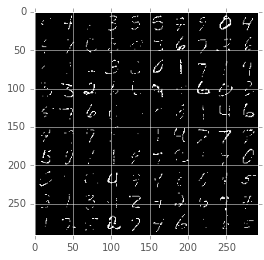

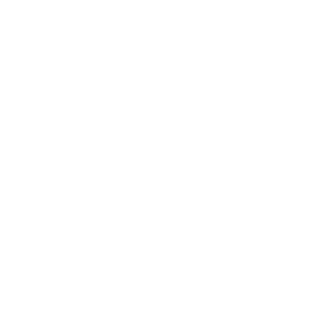

In [23]:
# Some parameters for training
batch_size = 5
n_epochs = 5

# We'll try to reconstruct the same first 100 images and show how
# The network does over the course of training.
examples = ds.X[:100]

# We'll store the reconstructions in a list
imgs = []
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
gif.build_gif(imgs, saveto='ae.gif', cmap='gray')

In [24]:
ipyd.Image(url='ae.gif?{}'.format(np.random.rand()),
           height=500, width=500)

<a name="convolutional-autoencoder"></a>
## Convolutional Autoencoder

To get even better encodings, we can also try building a convolutional network.  Why would a convolutional network perform any different to a fully connected one?  Let's see what we were doing in the fully connected network.  For every pixel in our input, we have a set of weights corresponding to every output neuron.  Those weights are unique to each pixel.  Each pixel gets its own row in the weight matrix.  That really doesn't make a lot of sense, since we would guess that nearby pixels are probably not going to be so different.  And we're not really encoding what's happening around that pixel, just what that one pixel is doing.

In a convolutional model, we're explicitly modeling what happens around a pixel.  And we're using the exact same convolutions no matter where in the image we are.  But we're going to use a lot of different convolutions.

Recall in session 1 we created a Gaussian and Gabor kernel and used this to convolve an image to either blur it or to accentuate edges.  Armed with what you know now, you could try to train a network to learn the parameters that map an untouched image to a blurred or edge filtered version of it.  What you should find is the kernel will look sort of what we built by hand.  I'll leave that as an excercise for you.

But in fact, that's too easy really.  That's just 1 filter you would have to learn.  We're going to see how we can use many convolutional filters, way more than 1, and how it will help us to encode the MNIST dataset.

To begin we'll need to reset the current graph and start over.

In [25]:
from tensorflow.python.framework.ops import reset_default_graph
reset_default_graph()

In [26]:
# And we'll create a placeholder in the tensorflow graph that will be able to get any number of n_feature inputs.
X = tf.placeholder(tf.float32, [None, n_features])

Since `X` is currently `[batch, height*width]`, we need to reshape it to a
4-D tensor to use it in a convolutional graph.  Remember back to the first session that in order to perform convolution, we have to use 4-dimensional tensors describing the:

`N x H x W x C`

We'll reshape our input placeholder by telling the `shape` parameter to be these new dimensions.  However, since our batch dimension is `None`, we cannot reshape without using the special value `-1`, which says that the size of that dimension should be computed so that the total size remains constant.  Since we haven't defined the batch dimension's shape yet, we use `-1` to denote this
dimension should not change size.

In [27]:
X_tensor = tf.reshape(X, [-1, 28, 28, 1])

We'll now setup the first convolutional layer.  Remember from Session 2 that the weight matrix for convolution should be

`[height x width x input_channels x output_channels]`

Think a moment about how this is different to the fully connected network.  In the fully connected network, every pixel was being multiplied by its own weight to every other neuron.  With a convolutional network, we use the extra dimensions to allow the same set of filters to be applied everywhere across an image.  This is also known in the literature as weight sharing, since we're sharing the weights no matter where in the input we are.  That's unlike the fully connected approach, which has unique weights for every pixel.  What's more is after we've performed the convolution, we've retained the spatial organization of the input.  We still have dimensions of height and width.  That's again unlike the fully connected network which effectively shuffles or takes int account information from everywhere, not at all caring about where anything is.  That can be useful or not depending on what we're trying to achieve.  Often, it is something we might want to do after a series of convolutions to encode translation invariance.  Don't worry about that for now.  With MNIST especially we won't need to do that since all of the numbers are in the same position.

Now with our tensor ready, we're going to do what we've just done with the fully connected autoencoder.  Except, instead of performing matrix multiplications, we're going to create convolution operations.  To do that, we'll need to decide on a few parameters including the filter size, how many convolution filters we want, and how many layers we want.  I'll start with a fairly small network, and let you scale this up in your own time.

In [28]:
n_filters = [16, 16, 16]
filter_sizes = [4, 4, 4]

Now we'll create a loop to create every layer's convolution, storing the convolution operations we create so that we can do the reverse.

In [29]:
current_input = X_tensor

# notice instead of having 784 as our input features, we're going to have
# just 1, corresponding to the number of channels in the image.
# We're going to use convolution to find 16 filters, or 16 channels of information in each spatial location we perform convolution at.
n_input = 1

# We're going to keep every matrix we create so let's create a list to hold them all
Ws = []
shapes = []

# We'll create a for loop to create each layer:
for layer_i, n_output in enumerate(n_filters):
    # just like in the last session,
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        # we'll keep track of the shapes of each layer
        # As we'll need these for the decoder
        shapes.append(current_input.get_shape().as_list())

        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable(
            name='W',
            shape=[
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input,
                n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

        # Now we'll convolve our input by our newly created W matrix
        h = tf.nn.conv2d(current_input, W,
            strides=[1, 2, 2, 1], padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # Finally we'll store the weight matrix so we can build the decoder.
        Ws.append(W)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

Now with our convolutional encoder built and the encoding weights stored, we'll reverse the whole process to decode everything back out to the original image.

In [30]:
# We'll first reverse the order of our weight matrices
Ws.reverse()
# and the shapes of each layer
shapes.reverse()
# and the number of filters (which is the same but could have been different)
n_filters.reverse()
# and append the last filter size which is our input image's number of channels
n_filters = n_filters[1:] + [1]

print(n_filters, filter_sizes, shapes)

[16, 16, 1] [4, 4, 4] [[None, 7, 7, 16], [None, 14, 14, 16], [None, 28, 28, 1]]


In [31]:
# and then loop through our convolution filters and get back our input image
# we'll enumerate the shapes list to get us there
for layer_i, shape in enumerate(shapes):
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):

        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = Ws[layer_i]

        # Now we'll convolve by the transpose of our previous convolution tensor
        h = tf.nn.conv2d_transpose(current_input, W,
            tf.pack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
            strides=[1, 2, 2, 1], padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

Now we have the reconstruction through the network:

In [32]:
Y = current_input
Y = tf.reshape(Y, [-1, n_features])

We can measure the cost and train exactly like before with the fully connected network:

0 0.0267173
1 0.0254708
2 0.0244566
3 0.0244303
4 0.0246654
5 0.0247506
6 0.0240583
7 0.0243283
8 0.0246409
9 0.024462


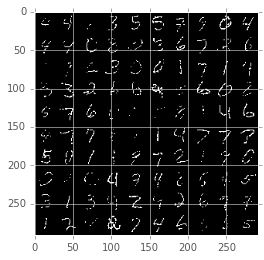

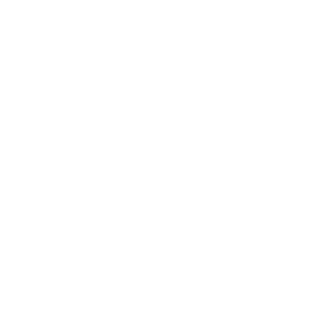

In [34]:
cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))
learning_rate = 0.001

# pass learning rate and cost to optimize
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Session to manage vars/train
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# Some parameters for training
batch_size = 100
n_epochs = 10

# We'll try to reconstruct the same first 100 images and show how
# The network does over the course of training.
examples = ds.X[:100]

# We'll store the reconstructions in a list
imgs = []
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
gif.build_gif(imgs, saveto='conv-ae.gif', cmap='gray')

In [35]:
ipyd.Image(url='conv-ae.gif?{}'.format(np.random.rand()),
           height=500, width=500)

<a name="denoising-autoencoder"></a>
## Denoising Autoencoder

The denoising autoencoder is a very simple extension to an autoencoder.  Instead of seeing the input, it is corrupted, for instance by masked noise.  but the reconstruction loss is still measured on the original uncorrupted image.  What this does is lets the model try to interpret occluded or missing parts of the thing it is reasoning about.  It would make sense for many models, that not every datapoint in an input is necessary to understand what is going on.  Denoising autoencoders try to enforce that, and as a result, the encodings at the middle most layer are often far more representative of the actual classes of different objects.

In the resources section, you'll see that I've included a general framework autoencoder allowing you to use either a fully connected or convolutional autoencoder, and whether or not to include denoising.  If you interested in the mechanics of how this works, I encourage you to have a look at the code.

<a name="variational-autoencoders"></a>
## Variational Autoencoders

A variational autoencoder extends the traditional autoencoder by using an additional layer called the variational layer.  It is actually two networks that are cleverly connected using a simple reparameterization trick, to help the gradient flow through both networks during backpropagation allowing both to be optimized.

We dont' have enough time to get into the details, but I'll try to quickly explain:  it tries to optimize the likelihood that a particular distribution would create an image, rather than trying to optimize simply the L2 loss at the end of the network.  Or put another way it hopes that there is some distribution that a distribution of image encodings could be defined as.  This is a bit tricky to grasp, so don't worry if you don't understand the details.  The major difference to hone in on is that instead of optimizing distance in the input space of pixel to pixel distance, which is actually quite arbitrary if you think about it... why would we care about the exact pixels being the same?  Human vision would not care for most cases, if there was a slight translation of our image, then the distance could be very high, but we would never be able to tell the difference.  So intuitively, measuring error based on raw pixel to pixel distance is not such a great approach.

Instead of relying on raw pixel differences, the variational autoencoder tries to optimize two networks.  One which says that given my pixels, I am pretty sure I can encode them to the parameters of some well known distribution, like a set of Gaussians, instead of some artbitrary density of values.  And then I can optimize the latent space, by saying that particular distribution should be able to represent my entire dataset, and I try to optimize the likelihood that it will create the images I feed through a network.  So distance is somehow encoded in this latent space.  Of course I appreciate that is a difficult concept so forgive me for not being able to expand on it in more details.

But to make up for the lack of time and explanation, I've included this model under the resources section for you to play with!  Just like the "vanilla" autoencoder, this one supports both fully connected, convolutional, and denoising models.

This model performs so much better than the vanilla autoencoder.  In fact, it performs so well that I can even manage to encode the majority of MNIST into 2 values.  The following visualization demonstrates the learning of a variational autoencoder over time.

<mnist visualization>

There are of course a lot more interesting applications of such a model.  You could for instance, try encoding a more interesting dataset, such as CIFAR which you'll find a wrapper for in the libs/datasets module.

<TODO: produce GIF visualization madness>

Or the celeb faces dataset:

<celeb dataset>

Or you could try encoding an entire movie.  We tried it with the copyleft movie, "Sita Sings The Blues".  Every 2 seconds, we stored an image of this movie, and then fed all of these images to a deep variational autoencoder.  This is the result.

<show sita sings the blues training images>

And I'm sure we can get closer with deeper nets and more train time.  But notice how in both celeb faces and sita sings the blues, the decoding is really blurred.  That is because of the assumption of the underlying representational space.  We're saying the latent space must be modeled as a gaussian, and those factors must be distributed as a gaussian.  This enforces a sort of discretization of my representation, enforced by the noise parameter of the gaussian.  In the last session, we'll see how we can avoid this sort of blurred representation and get even better decodings using a generative adversarial network.

For now, consider the applications that this method opens up.  Once you have an encoding of a movie, or image dataset, you are able to do some very interesting things.  You have effectively stored all the representations of that movie, although its not perfect of course.  But, you could for instance, see how another movie would be interpretted by the same network.  That's similar to what Terrance Broad did for his project on reconstructing blade runner and a scanner darkly, though he made use of both the variational autoencoder and the generative adversarial network.  We're going to look at that network in more detail in the last session.

We'll also look at how to properly handle very large datasets like celeb faces or the one used here to create the sita sings the blues autoencoder.  Taking every 60th frame of Sita Sings The Blues gives you aobut 300k images.  And that's a lot of data to try and load in all at once.  We had to size it down considerably, and make use of what's called a tensorflow input pipeline.  I've included all the code for training this network, which took about 1 day on a fairly powerful machine, but I will not get into the details of the image pipeline bits until session 5 when we look at generative adversarial networks.  I'm delaying this because we'll need to learn a few things along the way before we can build such a network.

<a name="predicting-image-labels"></a>
# Predicting Image Labels

We've just seen a variety of types of autoencoders and how they are capable of compressing information down to its inner most layer while still being able to retain most of the interesting details.  Considering that the CelebNet dataset was nearly 200 thousand images of 64 x 64 x 3 pixels, and we're able to express those with just an inner layer of 50 values, that's just magic basically.  Magic.

Okay, let's move on now to a different type of learning often called supervised learning.  Unlike what we just did, which is work with a set of data and not have any idea what that data should be *labeled* as, we're going to explicitly tell the network what we want it to be labeled by saying what the network should output for a given input.  In the previous cause, we just had a set of `Xs`, our images.  Now, we're going to have `Xs` and `Ys` given to us, and use the `Xs` to try and output the `Ys`.

With MNIST, the outputs of each image are simply what numbers are drawn in the input image.  The wrapper for grabbing this dataset from the libs module takes an additional parameter which I didn't talk about called `one_hot`.

In [36]:
from libs import datasets
# ds = datasets.MNIST(one_hot=True)

To see what this is doing, let's compare setting it to false versus true:

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
1


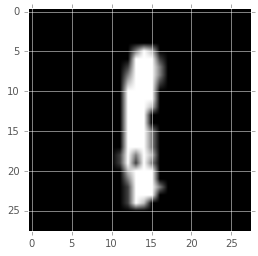

In [40]:
ds = datasets.MNIST(one_hot=False)
# let's look at the first label
print(ds.Y[0])
# okay and what does the input look like
plt.imshow(np.reshape(ds.X[0], (28, 28)), cmap='gray')
# great it is just the label of the image

3


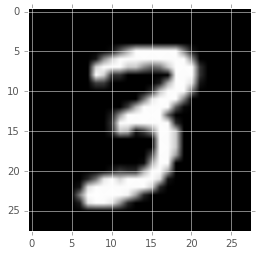

In [42]:
plt.figure()
# Let's look at the next one just to be sure
print(ds.Y[1])
# Yea the same idea
plt.imshow(np.reshape(ds.X[1], (28, 28)), cmap='gray')

And now let's look at what the one hot version looks like:

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


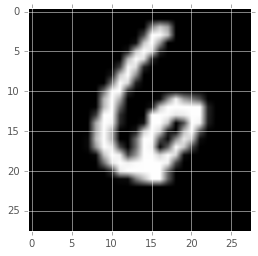

In [43]:
ds = datasets.MNIST(one_hot=True)
plt.figure()
plt.imshow(np.reshape(ds.X[0], (28, 28)), cmap='gray')
print(ds.Y[0])
# array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])
# Woah a bunch more numbers.  10 to be exact, which is also the number
# of different labels in the dataset.
plt.imshow(np.reshape(ds.X[1], (28, 28)), cmap='gray')
print(ds.Y[1])
# array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

So instead of have a number from 0-9, we have 10 numbers corresponding to the digits, 0-9, and each value is either 0 or 1.  Whichever digit the image represents is the one that is 1.

To summarize, we have all of the images of the dataset stored as:
`n_observations` x `n_features` tensor (n-dim array)

In [44]:
print(ds.X.shape)

(70000, 784)


And labels stored as `n_observations` x `n_labels` where each observation is a one-hot vector, where only one element is 1 indicating which class or label it is.

In [45]:
print(ds.Y.shape)
print(ds.Y[0])

(70000, 10)
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


<a name="one-hot-encoding"></a>
## One-Hot Encoding

Remember in the last session, we saw how to build a network capable of taking 2 inputs representing the row and column of an image, and predicting 3 outputs, the red, green, and blue colors.  Just like in our unsupervised model, instead of having 2 inputs, we'll now have 784 inputs, the brightness of every pixel in our image.  And instead of 3 outputs, like in our painting network from last session, or the 784 outputs we had in our unsupervised MNIST network, we'll now have 10 outputs representing the one-hot encoding of its label.

So why don't we just have 1 output?  A number from 0-9?  Wouldn't having 10 different outputs instead of just 1 be harder to learn?  Consider how we normally train the network.  We have to give it a cost which it will use to minimize.  What could our cost be if our output was just a single number, 0-9?  We would still have the true label, and the predicted label.  Could we just take the subtraction of the two values?  e.g. the network predicted 0, but the image was really the number 8.  Okay so then our distance could be:

In [46]:
# cost = tf.reduce_sum(tf.abs(y_pred - y_true))

NameError: name 'y_pred' is not defined

But in this example, the cost would be 8.  If the image was a 4, and the network predicted a 0 again, the cost would be 4... but isn't the network still just as wrong, not half as much as when the image was an 8?  In a one-hot encoding, the cost would be 1 for both, meaning they are both just as wrong.  So we're able to better measure the cost, by separating each class's label into its own dimension.

<a name="using-regression-for-classification"></a>
## Using Regression for Classification

The network we build will be trained to output values between 0 and 1.  They won't output exactly a 0 or 1.  But rather, they are able to produce any value.  0, 0.1, 0.2, ...  and that means the networks we've been using are actually performing regression.  In regression, the output is "continuous", rather than "discrete".  The difference is this: a *discrete* output means the network can only output one of a few things.  Like, 0, 1, 2, or 3, and that's it.  But a *continuous* output means it can output any real number.

In order to perform what's called classification, we're just simply going to look at whichever value is the highest in our one hot encoding.  In order to do that a little better, we're actually going interpret our one hot encodings as probabilities by scaling the total output by their sum.  What this does is allows us to understand that as we grow more confident in one prediction, we should grow less confident in all other predictions. We only have so much certainty to go around, enough to add up to 1.  If we think the image might also be the number 1, then we lose some certainty of it being the number 0.

It turns out there is a better cost function that simply measuring the distance between two vectors when they are probabilities.  It's called cross entropy:

\begin{align}
\Large{H(x) = -\sum{y_{\text{t}}(x) * \log(y_{\text{p}}(x))}}
\end{align}

What this equation does is measures the similarity of our prediction with our true distribution, by exponentially increasing error whenever our prediction gets closer to 1 when it should be 0, and similarly by exponentially increasing error whenever our prediction gets closer to 0, when it should be 1.   I won't go into more detail here, but just know that we'll be using this measure instead of a normal distance measure.

<a name="fully-connected-network"></a>
## Fully Connected Network

### Defining the Network

Let's see how our one hot encoding and our new cost function will come into play.  We'll create our network for predicting image classes in pretty much the same way we've created previous networks:

We will have as input to the network 28 x 28 values.

In [47]:
import tensorflow as tf
from libs import datasets
ds = datasets.MNIST(split=[0.8, 0.1, 0.1])
n_input = 28 * 28

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


As output, we have our 10 one-hot-encoding values

In [48]:
n_output = 10

We're going to create placeholders for our tensorflow graph.  We're going to set the first dimension to `None`.  Remember from our unsupervised model, this is just something special for placeholders which tells tensorflow "let this dimension be any possible value".  1, 5, 100, 1000, it doesn't matter.  Since we're going to pass our entire dataset in batches we'll need this to be say 100 images at a time.  But we'd also like to be able to send in only 1 image and see what the prediction of the network is.  That's why we let this dimension be flexible.

In [49]:
X = tf.placeholder(tf.float32, [None, n_input])

For the output, we'll have `None` again, since for every input, we'll have the same number of images that have outputs.

In [50]:
Y = tf.placeholder(tf.float32, [None, n_output])

Now we'll connect our input to the output with a linear layer.  Instead of `relu`, we're going to use `softmax`.  This will perform our exponential scaling of the outputs and make sure the output sums to 1, making it a probability.

In [51]:
# We'll use the linear layer we created in the last session, which I've stored in the libs file:
# NOTE: The lecture used an older version of this function which had a slightly different definition.
from libs import utils
Y_pred, W = utils.linear(
    x=X,
    n_output=n_output,
    activation=tf.nn.softmax,
    name='layer1')

And then we write our loss function as the cross entropy. And then we'll give our optimizer the `cross_entropy` measure just like we would with GradientDescent.  The formula for cross entropy is:

\begin{align}
\Large{H(x) = -\sum{\text{Y}_{\text{true}} * log(\text{Y}_{pred})}}
\end{align}

In [52]:
# We add 1e-12 because the log is undefined at 0.
cross_entropy = -tf.reduce_sum(Y * tf.log(Y_pred + 1e-12))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

To determine the correct class from our regression output, we have to take the maximum index.

In [56]:
predicted_y = tf.argmax(Y_pred, 1)
actual_y = tf.argmax(Y, 1)

We can then measure the accuracy by seeing whenever these are equal.  Note, this is just for us to see, and is not at all used to "train" the network!

In [57]:
correct_prediction = tf.equal(predicted_y, actual_y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

### Training the Network

The rest of the code will be exactly the same as before.  We chunk the training dataset into `batch_size` chunks, and let these images help train the network over a number of iterations.

In [59]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# Now actually do some training:
batch_size = 50
n_epochs = 5
for epoch_i in range(n_epochs):
    for batch_xs, batch_ys in ds.train.next_batch():
        sess.run(optimizer, feed_dict={
            X: batch_xs,
            Y: batch_ys
        })
    valid = ds.valid
    print(sess.run(accuracy,
                   feed_dict={
                       X: valid.images,
                       Y: valid.labels
                   }))

# Print final test accuracy:
test = ds.test
print(sess.run(accuracy,
               feed_dict={
                   X: test.images,
                   Y: test.labels
               }))

0.900715
0.913143
0.918286
0.920857
0.923429
0.927572


What we should see is the accuracy being printed after each "epoch", or after every run over the entire dataset.  Since we're using batches, we use the notion of an "epoch" to denote whenever we've gone through the entire dataset.

<a name="inspecting-the-network"></a>
### Inspecting the Trained Network

Let's try and now inspect *how* the network is accomplishing this task.  We know that our network is a single matrix multiplication of our 784 pixel values.  The weight matrix, `W`, should therefore have 784 rows.  As outputs, it has 10 values.  So the matrix is composed in the `linear` function as `n_input` x `n_output` values.  So the matrix is 784 rows x 10 columns.

<TODO: graphic w/ wacom showing network and matrix multiplication and pulling out single neuron/column>

In order to get this matrix, we could have had our `linear` function return the `tf.Tensor`.  But since everything is part of the tensorflow graph, and we've started using nice names for all of our operations, we can actually find this tensor using tensorflow:

In [60]:
# We first get the graph that we used to compute the network
g = tf.get_default_graph()

# And can inspect everything inside of it
[op.name for op in g.get_operations()]

['Placeholder',
 'Reshape/shape',
 'Reshape',
 'encoder/layer/0/W',
 'encoder/layer/0/W/Initializer/random_normal/shape',
 'encoder/layer/0/W/Initializer/random_normal/mean',
 'encoder/layer/0/W/Initializer/random_normal/stddev',
 'encoder/layer/0/W/Initializer/random_normal/RandomStandardNormal',
 'encoder/layer/0/W/Initializer/random_normal/mul',
 'encoder/layer/0/W/Initializer/random_normal',
 'encoder/layer/0/W/Assign',
 'encoder/layer/0/W/read',
 'encoder/layer/0/Conv2D',
 'encoder/layer/0/Relu',
 'encoder/layer/1/W',
 'encoder/layer/1/W/Initializer/random_normal/shape',
 'encoder/layer/1/W/Initializer/random_normal/mean',
 'encoder/layer/1/W/Initializer/random_normal/stddev',
 'encoder/layer/1/W/Initializer/random_normal/RandomStandardNormal',
 'encoder/layer/1/W/Initializer/random_normal/mul',
 'encoder/layer/1/W/Initializer/random_normal',
 'encoder/layer/1/W/Assign',
 'encoder/layer/1/W/read',
 'encoder/layer/1/Conv2D',
 'encoder/layer/1/Relu',
 'encoder/layer/2/W',
 'encoder/

Looking at the names of the operations, we see there is one `linear/W`.  But this is the `tf.Operation`.  Not the `tf.Tensor`.  The tensor is the result of the operation.  To get the result of the operation, we simply add ":0" to the name of the operation:

In [62]:
W = g.get_tensor_by_name('layer1/W:0')

We can use the existing session to compute the current value of this tensor:

In [63]:
W_arr = np.array(W.eval(session=sess))
print(W_arr.shape)

(784, 10)


And now we have our tensor!  Let's try visualizing every neuron, or every column of this matrix:

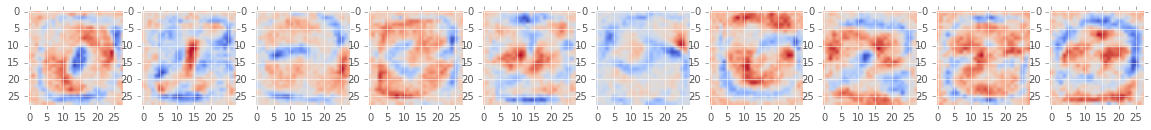

In [64]:
fig, ax = plt.subplots(1, 10, figsize=(20, 3))
for col_i in range(10):
    ax[col_i].imshow(W_arr[:, col_i].reshape((28, 28)), cmap='coolwarm')

We're going to use the `coolwarm` color map, which will use "cool" values, or blue-ish colors for low values.  And "warm" colors, red, basically, for high values.  So what we begin to see is that there is a weighting of all the input values, where pixels that are likely to describe that number are being weighted high, and pixels that are not likely to describe that number are being weighted low.  By summing all of these multiplications together, the network is able to begin to predict what number is in the image.  This is not a very good network though, and the representations it learns could still do a much better job.  We were only right about 93% of the time according to our accuracy.  State of the art models will get about 99.9% accuracy.

<a name="convolutional-networks"></a>
## Convolutional Networks

To get better performance, we can build a convolutional network.  We've already seen how to create a convolutional network with our unsupervised model.  We're going to make the same modifications here to help us predict the digit labels in MNIST.

### Defining the Network

I'll first reset the current graph, so we can build a new one.  We'll use tensorflow's nice helper function for doing this.

In [92]:
from tensorflow.python.framework.ops import reset_default_graph
reset_default_graph()

And just to confirm, let's see what's in our graph:

In [93]:
# We first get the graph that we used to compute the network
g = tf.get_default_graph()

# And can inspect everything inside of it
[op.name for op in g.get_operations()]

[]

Great.  Empty.

Now let's get our dataset, and create some placeholders like before:

In [94]:
# We'll have placeholders just like before which we'll fill in later.
ds = datasets.MNIST(one_hot=True, split=[0.8, 0.1, 0.1])
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Since `X` is currently `[batch, height*width]`, we need to reshape to a
4-D tensor to use it in a convolutional graph.  Remember, in order to perform convolution, we have to use 4-dimensional tensors describing the:

`N x H x W x C`

We'll reshape our input placeholder by telling the `shape` parameter to be these new dimensions and we'll use `-1` to denote this dimension should not change size.

In [95]:
X_tensor = tf.reshape(X, [-1, 28, 28, 1])

We'll now setup the first convolutional layer.  Remember that the weight matrix for convolution should be

`[height x width x input_channels x output_channels]`

Let's create 32 filters.  That means every location in the image, depending on the stride I set when we perform the convolution, will be filtered by this many different kernels.  In session 1, we convolved our image with just 2 different types of kernels.  Now, we're going to let the computer try to find out what 32 filters helps it map the input to our desired output via our training signal.

In [96]:
filter_size = 5
n_filters_in = 1
n_filters_out = 32
W_1 = tf.get_variable(
    name='W',
    shape=[filter_size, filter_size, n_filters_in, n_filters_out],
    initializer=tf.random_normal_initializer())

Bias is always `[output_channels]` in size.

In [97]:
b_1 = tf.get_variable(
    name='b',
    shape=[n_filters_out],
    initializer=tf.constant_initializer())

Now we can build a graph which does the first layer of convolution:
We define our stride as `batch` x `height` x `width` x `channels`.  This has the effect of resampling the image down to half of the size.

In [98]:
h_1 = tf.nn.relu(
    tf.nn.bias_add(
        tf.nn.conv2d(input=X_tensor,
                     filter=W_1,
                     strides=[1, 2, 2, 1],
                     padding='SAME'),
        b_1))

And just like the first layer, add additional layers to create a deep net.

In [99]:
n_filters_in = 32
n_filters_out = 64
W_2 = tf.get_variable(
    name='W2',
    shape=[filter_size, filter_size, n_filters_in, n_filters_out],
    initializer=tf.random_normal_initializer())
b_2 = tf.get_variable(
    name='b2',
    shape=[n_filters_out],
    initializer=tf.constant_initializer())
h_2 = tf.nn.relu(
    tf.nn.bias_add(
        tf.nn.conv2d(input=h_1,
                 filter=W_2,
                 strides=[1, 2, 2, 1],
                 padding='SAME'),
        b_2))

4d -> 2d

In [103]:
# We'll now reshape so we can connect to a fully-connected/linear layer:
h_2_flat = tf.reshape(h_2, [-1, 7 * 7 * n_filters_out])

Create a fully-connected layer:

In [104]:
# NOTE: This uses a slightly different version of the linear function than the lecture!
h_3, W = utils.linear(h_2_flat, 128, activation=tf.nn.relu, name='fc_1')

ValueError: Variable fc_1/W already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "/home/ryan/git_ryan/Tensorflow_CADL/session-3/libs/utils.py", line 625, in linear
    initializer=tf.contrib.layers.xavier_initializer())
  File "<ipython-input-101-dcbe92c72bcc>", line 2, in <module>
    h_3, W = utils.linear(h_2_flat, 128, activation=tf.nn.relu, name='fc_1')
  File "/home/ryan/anaconda2/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


And one last fully-connected layer which will give us the correct number of outputs, and use a softmax to expoentially scale the outputs and convert them to a probability:

In [105]:
# NOTE: This uses a slightly different version of the linear function than the lecture!
Y_pred, W = utils.linear(h_3, n_output, activation=tf.nn.softmax, name='fc_2')

<TODO: Draw as graphical representation>

### Training the Network

The rest of the training process is the same as the previous network.  We'll define loss/eval/training functions:

In [106]:
cross_entropy = -tf.reduce_sum(Y * tf.log(Y_pred + 1e-12))
optimizer = tf.train.AdamOptimizer().minimize(cross_entropy)

Monitor accuracy:

In [108]:
correct_prediction = tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

And create a new session to actually perform the initialization of all the variables:

In [109]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

Then we'll train in minibatches and report accuracy:

In [110]:
batch_size = 50
n_epochs = 10
for epoch_i in range(n_epochs):
    for batch_xs, batch_ys in ds.train.next_batch():
        sess.run(optimizer, feed_dict={
            X: batch_xs,
            Y: batch_ys
        })
    valid = ds.valid
    print(sess.run(accuracy,
                   feed_dict={
                       X: valid.images,
                       Y: valid.labels
                   }))

# Print final test accuracy:
test = ds.test
print(sess.run(accuracy,
               feed_dict={
                   X: test.images,
                   Y: test.labels
               }))

0.381857
0.478429
0.952715
0.964429
0.973
0.973429
0.974572
0.975857
0.968572
0.976429
0.995715


<TODO: Fun timelapse of waiting>

### Inspecting the Trained Network

Let's take a look at the kernels we've learned using the following montage function, similar to the one we've been using for creating image montages, except this one is suited for the dimensions of convolution kernels instead of 4-d images.  So it has the height and width first, unlike images which have batch then height then width.  We'll use this function to visualize every convolution kernel in the first and second layers of our network.

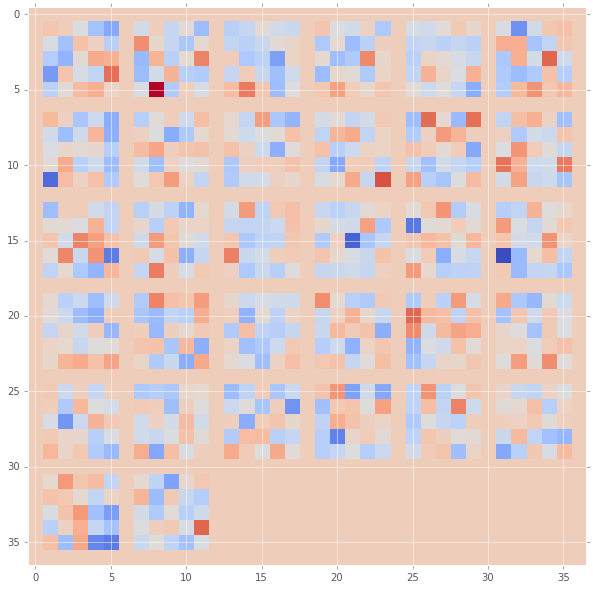

In [111]:
from libs.utils import montage_filters
W1 = sess.run(W_1)
plt.figure(figsize=(10, 10))
plt.imshow(montage_filters(W1), cmap='coolwarm', interpolation='nearest')

What we're looking at are all of the convolution kernels that have been learned.  Compared to the previous network we've learned, it is much harder to understand what's happening here.  But let's try and explain these a little more.  The kernels that have been automatically learned here are responding to edges of different scales, orientations, and rotations.  It's likely these are really describing parts of letters, or the strokes that make up letters.  Put another way, they are trying to get at the "information" in the image by seeing what changes.

That's a pretty fundamental idea.  That information would be things that change.  Of course, there are filters for things that aren't changing as well. Some filters may even seem to respond to things that are mostly constant.  However, if our network has learned a lot of filters that look like that, it's likely that the network hasn't really learned anything at all.  The flip side of this is if the filters all look more or less random.  That's also a bad sign.

Let's try looking at the second layer's kernels:

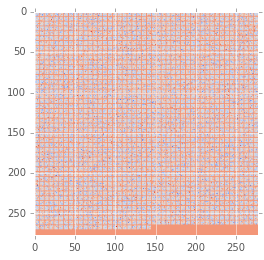

In [112]:
W2 = sess.run(W_2)
plt.imshow(montage_filters(W2 / np.max(W2)), cmap='coolwarm')

It's really difficult to know what's happening here.  There are many more kernels in this layer.  They've already passed through a set of filters and an additional non-linearity.  How can we really know what the network is doing to learn its objective function?  The important thing for now is to see that most of these filters are different, and that they are not all constant or uniformly activated.  That means it's really doing something, but we aren't really sure yet how to see how that effects the way we think of and perceive the image.  In the next session, we'll learn more about how we can start to interrogate these deeper representations and try to understand what they are encoding.  Along the way, we'll learn some pretty amazing tricks for producing entirely new aesthetics that eventually led to the "deep dream" viral craze.

<a name="savingloading-models"></a>
# Saving/Loading Models

Tensorflow provides a few ways of saving/loading models.  The easiest way is to use a checkpoint.  Though, this really useful while you are training your network.  When you are ready to deploy or hand out your network to others, you don't want to pass checkpoints around as they contain a lot of unnecessary information, and it also requires you to still write code to create your network.  Instead, you can create a protobuf which contains the definition of your graph and the model's weights.  Let's see how to do both:

<a name="checkpoint"></a>
## Checkpoint

Creating a checkpoint requires you to have already created a set of operations in your tensorflow graph.  Once you've done this, you'll create a session like normal and initialize all of the variables.  After this, you create a `tf.train.Saver` which can restore a previously saved checkpoint, overwriting all of the variables with your saved parameters.

In [117]:
import os

sess = tf.Session()
init_op = tf.initialize_all_variables()
saver = tf.train.Saver()
sess.run(init_op)
if os.path.exists("model.ckpt"):
    saver.restore(sess, "model.ckpt")
    print("Model restored.")

Model restored.


Creating the checkpoint is easy.  After a few iterations of training, depending on your application say between 1/10 of the time to train the full model, you'll want to write the saved model.  You can do this like so:

In [118]:
save_path = saver.save(sess, "./model.ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: ./model.ckpt


<a name="protobuf"></a>
## Protobuf

The second way of saving a model is really useful for when you don't want to pass around the code for producing the tensors or computational graph itself.  It is also useful for moving the code to deployment or for use in the C++ version of Tensorflow.  To do this, you'll want to run an operation to convert all of your trained parameters into constants.  Then, you'll create a second graph which copies the necessary tensors, extracts the subgraph, and writes this to a model.  The summarized code below shows you how you could use a checkpoint to restore your models parameters, and then export the saved model as a protobuf.

In [119]:
path='./'
ckpt_name = 'model.ckpt'
fname = 'model.tfmodel'
dst_nodes = ['Y']
g_1 = tf.Graph()
with tf.Session(graph=g_1) as sess:
    x = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
    # Replace this with some code which will create your tensorflow graph:
    net = create_network()
    sess.run(tf.initialize_all_variables())
    saver.restore(sess, ckpt_name)
    graph_def = tf.python.graph_util.convert_variables_to_constants(
        sess, sess.graph_def, dst_nodes)
g_2 = tf.Graph()
with tf.Session(graph=g_2) as sess:
    tf.train.write_graph(
        tf.python.graph_util.extract_sub_graph(
            graph_def, dst_nodes), path, fname, as_text=False)

NameError: name 'create_network' is not defined

When you wanted to import this model, now you wouldn't need to refer to the checkpoint or create the network by specifying its placeholders or operations.  Instead, you'd use the `import_graph_def` operation like so:

In [120]:
with open("model.tfmodel", mode='rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

tf.import_graph_def(net['graph_def'], name='model')

FileNotFoundError: [Errno 2] No such file or directory: 'model.tfmodel'

<a name="wrap-up"></a>
# Wrap Up

In the next session, we'll learn some very powerful techniques for exploring the representations learned by these kernels, and how we can better understand what they are learning.  We'll look at state of the art deep networks for image recognition and interrogate what they've learned using techniques that led the public to Deep Dream.

<a name="reading"></a>
# Reading

Bourlard, H.; Kamp, Y. (1988). "Auto-association by multilayer perceptrons and singular value decomposition". Biological Cybernetics 59 (4–5): 291–294.

G. E. Hinton, R. R. Salakhutdinov. Reducing the Dimensionality of Data with Neural Networks.  Science, 28 Jul 2006. Vol. 313, Issue 5786, pp. 504-507. 
DOI: 10.1126/science.1127647. http://science.sciencemag.org/content/313/5786/504.abstract

Bengio, Y. (2009). "Learning Deep Architectures for AI". Foundations and Trends in Machine Learning 2. doi:10.1561/2200000006

Vincent, Pascal; Larochelle, Hugo; Lajoie, Isabelle; Bengio, Yoshua; Manzagol, Pierre-Antoine (2010). "Stacked Denoising Autoencoders: Learning Useful Representations in a Deep Network with a Local Denoising Criterion". The Journal of Machine Learning Research 11: 3371–3408.

Auto-Encoding Variational Bayes, Kingma, D.P. and Welling, M., ArXiv e-prints, 2013 http://arxiv.org/abs/1312.6114